# Preprocessing

In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr


import yfinance as yf

### Select the tickers and timeframe

In [ ]:
yf.pdr_override()

tickers =  ["AAPL", "GE", "JPM", "MSFT", "VOD", "NKE", "NVDA", "MMM"]
df = pdr.get_data_yahoo([tickers][0], start='2010-01-01', end="2017-01-01")

data = df.copy()
# we copy the neighbour values to NaN entries
data['Adj Close'] = data['Adj Close'].ffill()
df = df.bfill(axis=1)
data['Adj Close'] = data['Adj Close'].bfill()
df = df.bfill(axis=1)

data = data['Adj Close']
data.head(2)

In [ ]:
# Debug data

dft = data.iloc[-1,:] #pandas series of the day (there are the ticket and the value)
print(dft)
dft_list = dft.values.tolist() #transform pandas series to a list of values of each ticket
print(dft_list)
state = [0] + dft_list + [0]*8 #0 account balance | 1-8 price of the tickets | 9-16 owned shares
print(state)

### We check that tehre are no NAN values

In [ ]:
data.isna().sum()

### Check if all tickers have the same number of data points

In [ ]:
no_datasets = []
for i in tickers:
    no_data_points = len(data[i])
    no_datasets.append((i,no_data_points))
    data_points_df = pd.DataFrame(no_datasets)

data_points_df.head()

### Define the start-end dates for the training and testing data

In [ ]:
train_pct = 0.8
samples_train = int(train_pct*len(data))
data_train = data[:samples_train]
data_test = data[samples_train:]

In [ ]:
data_test.head()

### Visualization

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
for i in tickers:
    plt.plot(data[i], label=i)

# only one line may be specified; full height
plt.axvline(pd.to_datetime('2015-08-10'), color='black', linestyle='--', lw=2)
plt.legend()
plt.margins(x=0)
plt.ylabel("Closing Share Prise (USD)")
plt.xlabel("Time (Years)")
plt.savefig('data0.png',bbox_inches='tight')

# -----------------------------------------------
# ----------------------------------------------- 

# Evaluating models

## Deep Reinfrocement Learning

In [ ]:
!pip install pip==21.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import random
from deepRL import StockEnvTrade, train, DRL_prediction
from stable_baselines3.common.vec_env import DummyVecEnv

In [ ]:
rebalance_period = 1
re_df = data.iloc[::rebalance_period, :]
train_re_df = data_train.iloc[::rebalance_period, :]
test_re_df = data_test.iloc[::rebalance_period, :]

In [ ]:
timesteps = 25000
runs = 10
policy = "MlpPolicy"
length = test_re_df.shape[0]
stocks = test_re_df.shape[1]

### PPO

In [ ]:
algo = "PPO"
Cumulative_returns_daily_drl_ppo = np.zeros([runs, length])
portfolio_weights_ppo = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ppo[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ppo[i])
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo[i]),axis=1)
    Cumulative_returns_daily_drl_ppo[i] = (1+return_stocks_ppo).cumprod()
    i = i+1

Training time:  2.2582510789235433  minutes
Training time:  2.0736674904823302  minutes
Training time:  2.040127698580424  minutes
Training time:  2.0271355589230855  minutes
Training time:  2.0726234237353007  minutes
Training time:  2.067313472429911  minutes
Training time:  2.206823396682739  minutes
Training time:  2.060117761294047  minutes
Training time:  2.0874988635381064  minutes
Training time:  2.058710245291392  minutes


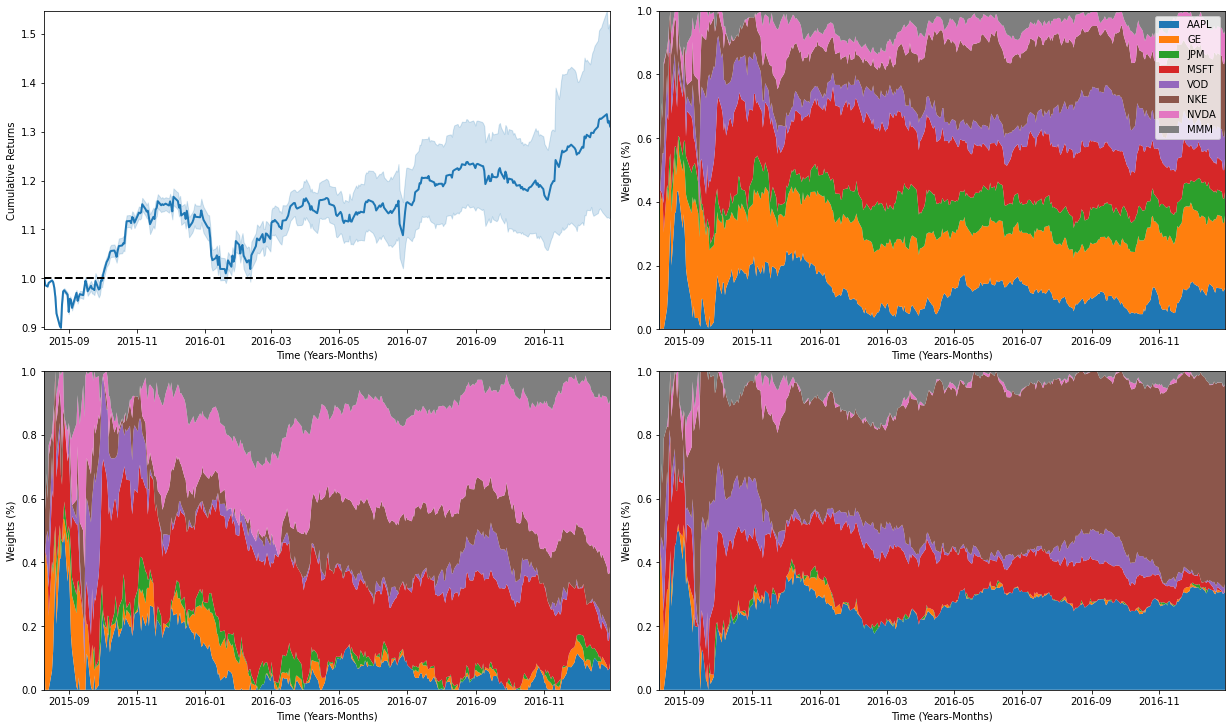

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

ppo_mean = np.mean(np.array(Cumulative_returns_daily_drl_ppo),axis=0)
ppo_std = np.std(np.array(Cumulative_returns_daily_drl_ppo),axis=0)

axs[0,0].plot(test_re_df.index, ppo_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, ppo_mean - ppo_std, ppo_mean + ppo_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = np.mean(np.array(portfolio_weights_ppo),axis=0)
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
df = pd.DataFrame (portfolio_weights_ppo_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

In [ ]:
print(f"Last Mean: {ppo_mean[-1]}")
print(f"Last Std: {ppo_std[-1]}")

Last Mean: 1.3109580868611928
Last Std: 0.1870832038472459


### A2C

In [ ]:
algo = "A2C"
Cumulative_returns_daily_drl_a2c = np.zeros([runs, length])
portfolio_weights_a2c = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_a2c[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_a2c[i]) 
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c[i]),axis=1)
    Cumulative_returns_daily_drl_a2c[i] = (1+return_stocks_a2c).cumprod()
    i = i+1

Training time:  2.0673712491989136  minutes
Training time:  2.0318087935447693  minutes
Training time:  2.0044187744458517  minutes
Training time:  2.000640348593394  minutes
Training time:  2.0122162342071532  minutes
Training time:  2.0067929585774738  minutes
Training time:  2.006928304831187  minutes
Training time:  2.020361622174581  minutes
Training time:  1.9965439478556315  minutes
Training time:  2.0176683982213337  minutes


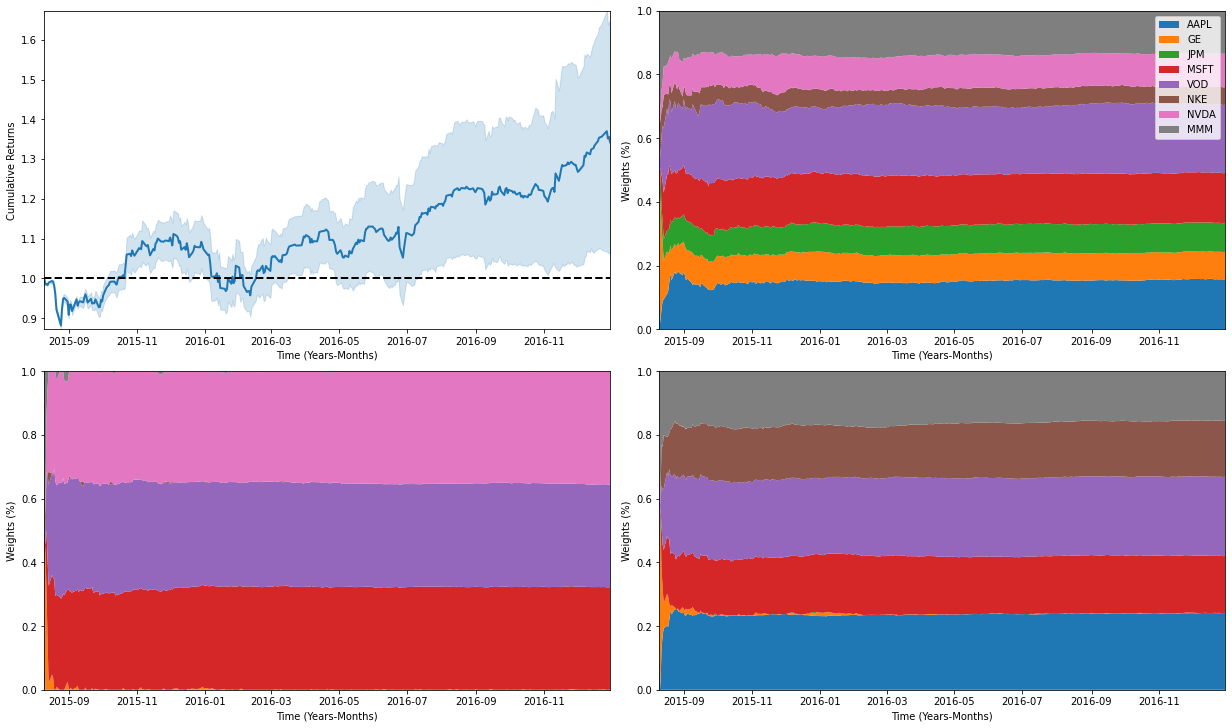

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

a2c_mean = np.mean(np.array(Cumulative_returns_daily_drl_a2c),axis=0)
a2c_std = np.std(np.array(Cumulative_returns_daily_drl_a2c),axis=0)

axs[0,0].plot(test_re_df.index, a2c_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, a2c_mean - a2c_std, a2c_mean + a2c_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = np.mean(np.array(portfolio_weights_a2c),axis=0)
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
df = pd.DataFrame (portfolio_weights_a2c_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

In [ ]:
print(f"Last Mean: {a2c_mean[-1]}")
print(f"Last Std: {a2c_std[-1]}")

Last Mean: 1.3422513940928855
Last Std: 0.2815173848427577


### DDPG

In [ ]:
algo = "DDPG"
Cumulative_returns_daily_drl_ddpg = np.zeros([runs, length])
portfolio_weights_ddpg = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_ddpg[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_ddpg[i]) 
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg[i]),axis=1)
    Cumulative_returns_daily_drl_ddpg[i] = (1+return_stocks_ddpg).cumprod()
    i = i+1

Training time:  3.9751039663950603  minutes
Training time:  3.9701138377189635  minutes
Training time:  3.9745258847872416  minutes
Training time:  3.890887709458669  minutes
Training time:  3.9473056276639302  minutes
Training time:  3.9103372852007547  minutes
Training time:  3.951495635509491  minutes
Training time:  3.9332757115364076  minutes
Training time:  4.000147187709809  minutes
Training time:  3.9734033425649007  minutes


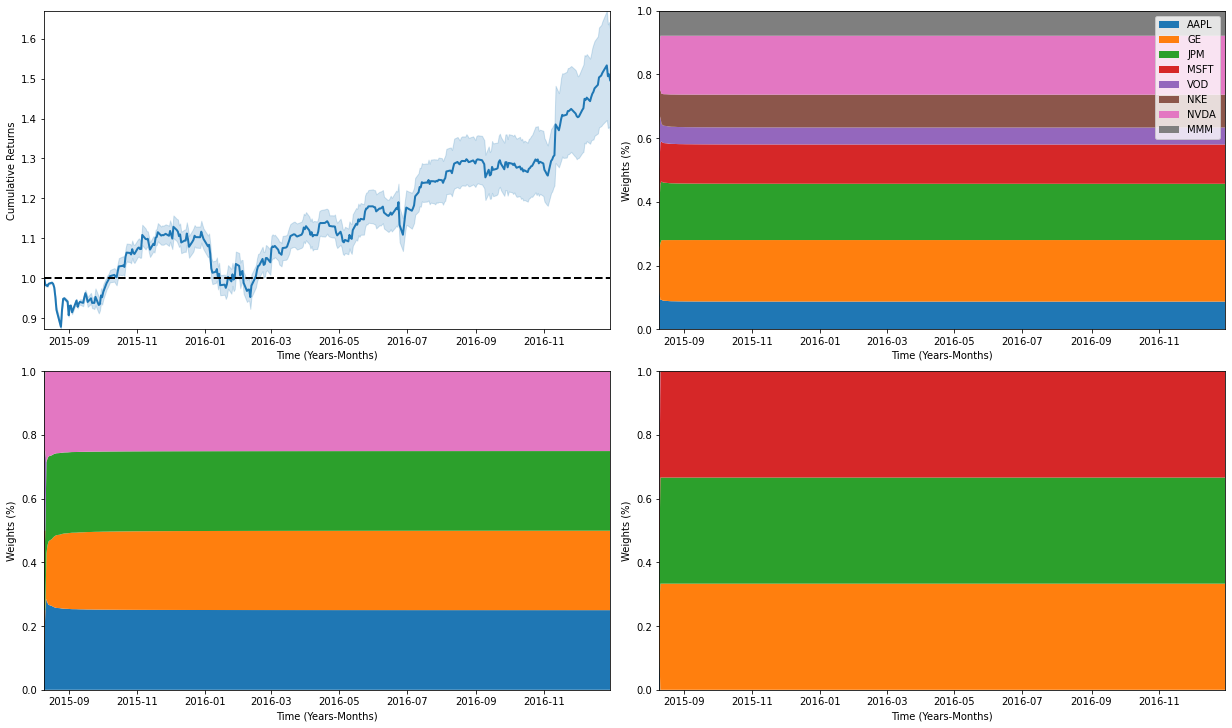

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

ddpg_mean = np.mean(np.array(Cumulative_returns_daily_drl_ddpg),axis=0)
ddpg_std = np.std(np.array(Cumulative_returns_daily_drl_ddpg),axis=0)

axs[0,0].plot(test_re_df.index, ddpg_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, ddpg_mean - ddpg_std, ddpg_mean + ddpg_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ddgpc_ = np.mean(np.array(portfolio_weights_ddpg),axis=0)
df = pd.DataFrame (portfolio_weights_ddgpc_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_ddgpc_ = portfolio_weights_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
df = pd.DataFrame (portfolio_weights_ddgpc_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_ddgpc_ = portfolio_weights_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
df = pd.DataFrame (portfolio_weights_ddgpc_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

In [ ]:
print(f"Last Mean: {ddpg_mean[-1]}")
print(f"Last Std: {ddpg_std[-1]}")

Last Mean: 1.4957455829425075
Last Std: 0.12626888928813726


### SAC

In [ ]:
algo = "SAC"
Cumulative_returns_daily_drl_sac = np.zeros([runs, length])
portfolio_weights_sac = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_sac[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_sac[i]) 
    cont = cont +1
    if check != length:
        continue
    
    return_stocks = test_re_df.pct_change()
    return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac[i]),axis=1)
    Cumulative_returns_daily_drl_sac[i] = (1+return_stocks_sac).cumprod()
    i = i+1

Training time:  6.24958518743515  minutes
Training time:  6.245691486199697  minutes
Training time:  6.264909096558889  minutes
Training time:  6.296005733807882  minutes
Training time:  6.270184950033824  minutes
Training time:  6.272020236651103  minutes
Training time:  6.2364107688268025  minutes
Training time:  6.211370078722636  minutes
Training time:  6.21687829097112  minutes
Training time:  6.2667323589324955  minutes


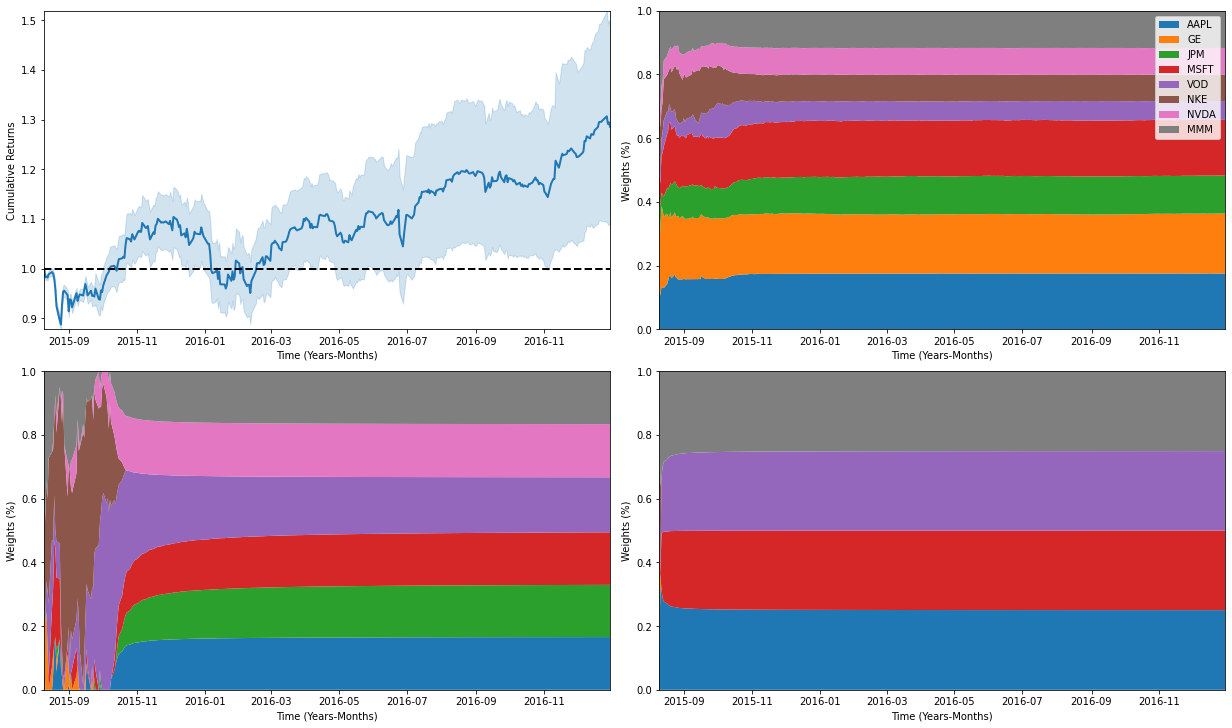

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

sac_mean = np.mean(np.array(Cumulative_returns_daily_drl_sac),axis=0)
sac_std = np.std(np.array(Cumulative_returns_daily_drl_sac),axis=0)

axs[0,0].plot(test_re_df.index, sac_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, sac_mean - sac_std, sac_mean + sac_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = np.mean(np.array(portfolio_weights_sac),axis=0)
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = portfolio_weights_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_sac_ = portfolio_weights_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
df = pd.DataFrame (portfolio_weights_sac_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

In [ ]:
print(f"Last Mean: {sac_mean[-1]}")
print(f"Last Std: {sac_std[-1]}")

Last Mean: 1.2852477168745444
Last Std: 0.1994573229477776


### TD3

In [ ]:
algo = "TD3"
Cumulative_returns_daily_drl_td3 = np.zeros([runs, length])
portfolio_weights_td3 = np.zeros([runs, length, stocks])

i=0
cont=0
while (i<runs):

    train_env = DummyVecEnv([lambda: StockEnvTrade(df = train_re_df)])
    model = train(algo, policy, train_env, timesteps, seed=cont, save=False)

    test_env = DummyVecEnv([lambda: StockEnvTrade(df = test_re_df)])
    test_obs = test_env.reset()

    portfolio_weights_td3[i] = np.array(DRL_prediction(model, test_re_df, test_env, test_obs))
    
    check = np.sum(portfolio_weights_td3[i])
    cont = cont +1
    if check != length:
        continue

    return_stocks = test_re_df.pct_change()
    return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3[i]),axis=1)
    Cumulative_returns_daily_drl_td3[i] = (1+return_stocks_td3).cumprod()
    i = i+1

Training time:  3.9033957282702128  minutes
Training time:  3.9044962485631305  minutes
Training time:  3.932175330320994  minutes
Training time:  3.8829553802808126  minutes
Training time:  3.8311388889948526  minutes
Training time:  3.821416970094045  minutes
Training time:  3.7641998887062074  minutes
Training time:  3.768766911824544  minutes
Training time:  3.823899058500926  minutes
Training time:  3.8039636254310607  minutes


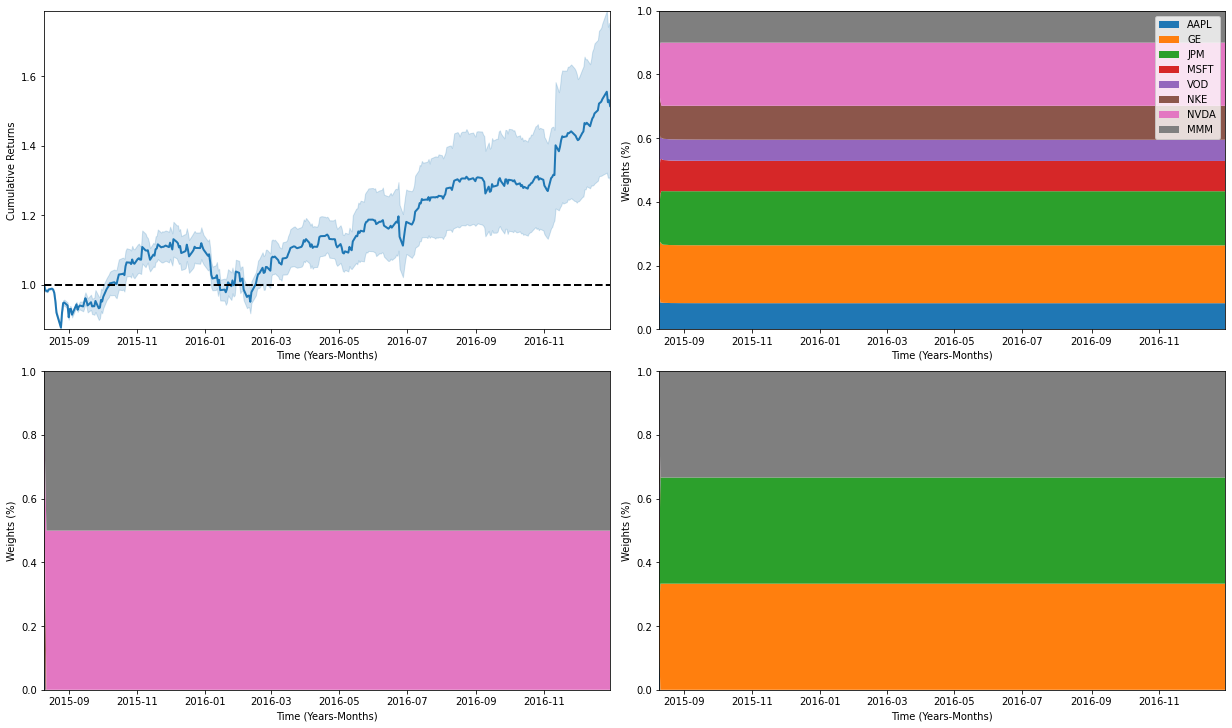

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

td3_mean = np.mean(np.array(Cumulative_returns_daily_drl_td3),axis=0)
td3_std = np.std(np.array(Cumulative_returns_daily_drl_td3),axis=0)

axs[0,0].plot(test_re_df.index, td3_mean, color='tab:blue', linewidth =2.0)
axs[0,0].fill_between(test_re_df.index, td3_mean - td3_std, td3_mean + td3_std, alpha=0.2, color='tab:blue')
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].axhline(1, color='black', linestyle='--', lw=2)
axs[0,0].set_ylabel("Cumulative Returns")
axs[0,0].set_xlabel("Time (Years-Months)")

portfolio_weights_td3_ = np.mean(np.array(portfolio_weights_td3),axis=0)
df = pd.DataFrame (portfolio_weights_td3_, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

portfolio_weights_td3_ = portfolio_weights_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
df = pd.DataFrame (portfolio_weights_td3_, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

portfolio_weights_td3_ = portfolio_weights_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
df = pd.DataFrame (portfolio_weights_td3_, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")

plt.savefig(algo+'_'+str(timesteps)+'_'+str(rebalance_period)+'_drl0.png',bbox_inches='tight')

In [ ]:
print(f"Last Mean: {td3_mean[-1]}")
print(f"Last Std: {td3_std[-1]}")

Last Mean: 1.514553512188699
Last Std: 0.21285734808863774


## Traditional approaches

In [ ]:
!pip install PyPortfolioOpt
!pip install pybind11
!pip install path/cvxpy‑version.whl
!pip install riskfolio-lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 6.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 18.3 MB/s eta 0:00:00
ERROR: cvxpy‑version.whl is not a valid wheel filename.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 92.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 805.8 kB/s eta 0:00:00
  Created wheel for riskfolio-lib: filename=Riskfolio_Lib-4.0.3-cp39-cp39-linux_x86_64.whl size=178547 sha256=69f7c993962809db51aac2e4e1471f12ce6342500cb7f8bfeef6e1909d092b28
  Stored in directory: /roo

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import riskfolio as rp

In [ ]:
# working days in a year 252
window = 50
start = len(train_re_df)-window
data = re_df.iloc[start:]
data = data.reset_index(drop=True)

### Min-Variance Portfolio Allocation

In [ ]:
portfolio_weights_min_var = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_var.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)
    
    try:
        weights = ef.max_sharpe()
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True,
        )

    portfolio_weights_min_var[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Text(0.5, 0, 'Time (Years-Months)')

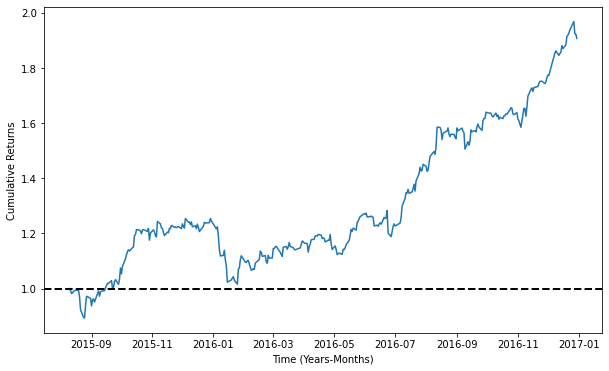

In [ ]:
return_stocks = test_re_df.pct_change()
return_stocks_min_var = np.sum(return_stocks.multiply(portfolio_weights_min_var),axis=1)
Cumulative_returns_daily_min_var = (1+return_stocks_min_var).cumprod()
plt.plot(Cumulative_returns_daily_min_var)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

Text(0.5, 0, 'Time (Years-Months)')

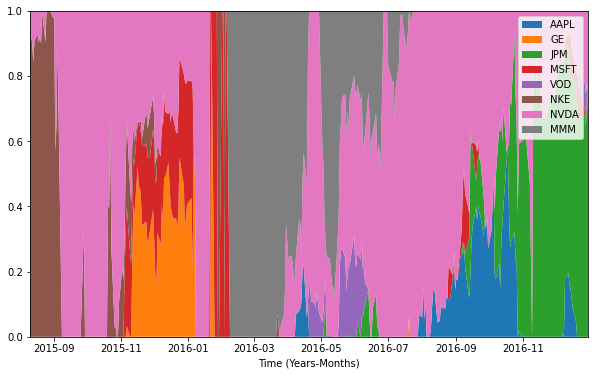

In [ ]:
df = pd.DataFrame (portfolio_weights_min_var, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

### Min volatility

In [ ]:
portfolio_weights_min_vol = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_vol.shape[0]):    
    sel = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(sel)
    S = risk_models.sample_cov(sel)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S)  
    weights = ef.min_volatility() 
   
    portfolio_weights_min_vol[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Text(0.5, 0, 'Time (Years-Months)')

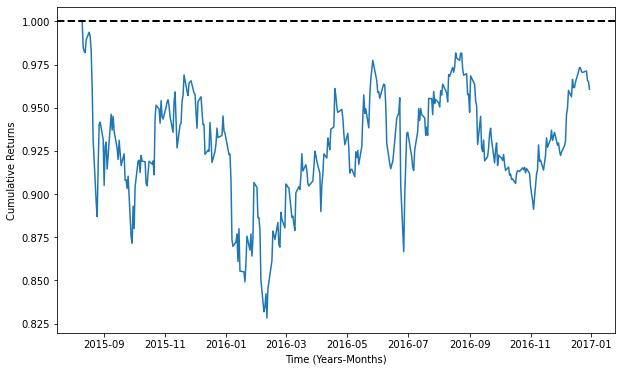

In [ ]:
return_stocks_min_vol = np.sum(return_stocks.multiply(portfolio_weights_min_vol),axis=1)
Cumulative_returns_daily_min_vol = (1+return_stocks_min_vol).cumprod()
plt.plot(Cumulative_returns_daily_min_vol)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

Text(0.5, 0, 'Time (Years-Months)')

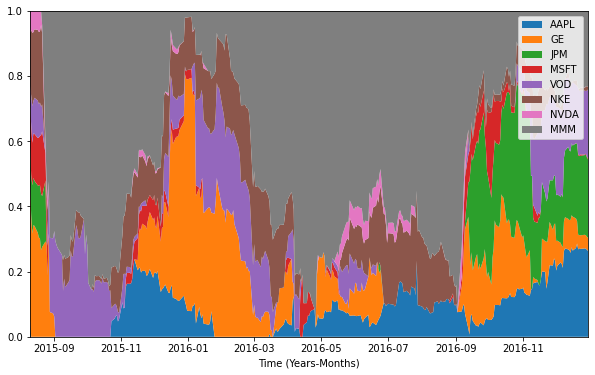

In [ ]:
df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

### Risk Parity

In [ ]:
portfolio_weights_risk = np.zeros([test_re_df.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_risk.shape[0]):    
    sel = data.iloc[i:window+i]
   
    # Building the portfolio object
    port = rp.Portfolio(returns=sel)

    # Calculating optimal portfolio
    # Select method and estimate input parameters:
    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    model='Classic' # Could be Classic (historical) or FM (Factor Model)
    rm = 'MV' # Risk measure used, this time will be variance
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    b = None # Risk contribution constraints vector
    weights = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)
   
    portfolio_weights_risk[idx]=np.squeeze(np.array(weights))
    idx +=1  

/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: 

Text(0.5, 0, 'Time (Years-Months)')

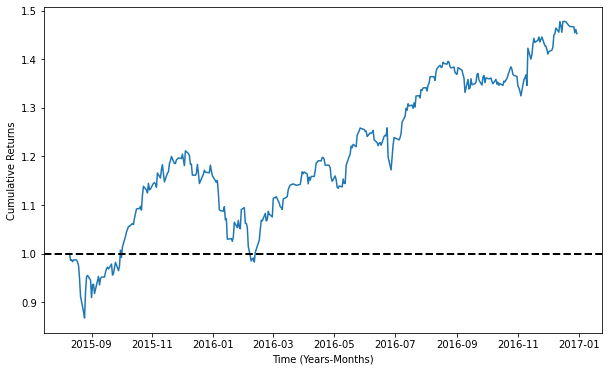

In [ ]:
return_stocks = test_re_df.pct_change()
return_stocks_risk = np.sum(return_stocks.multiply(portfolio_weights_risk),axis=1)
Cumulative_returns_daily_risk = (1+return_stocks_risk).cumprod()
plt.plot(Cumulative_returns_daily_risk)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

Text(0.5, 0, 'Time (Years-Months)')

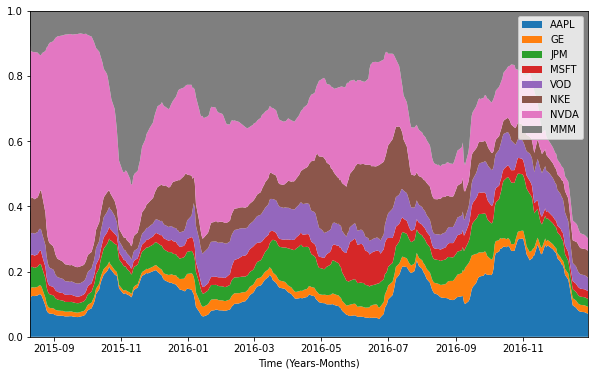

In [ ]:
df = pd.DataFrame (portfolio_weights_risk, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

### Equal weighting

In [ ]:
portfolio_weights_equal = np.ones([test_re_df.shape[0],test_re_df.shape[1]])/test_re_df.shape[1]

Text(0.5, 0, 'Time (Years-Months)')

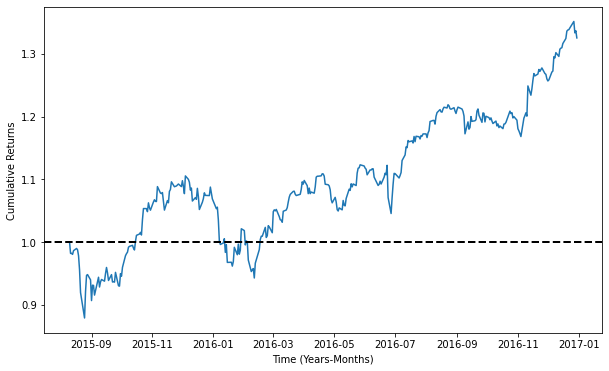

In [ ]:
return_stocks = test_re_df.pct_change()
return_stocks_equal = np.sum(return_stocks.multiply(portfolio_weights_equal),axis=1)
Cumulative_returns_daily_equal = (1+return_stocks_equal).cumprod()
plt.plot(Cumulative_returns_daily_equal)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

Text(0.5, 0, 'Time (Years-Months)')

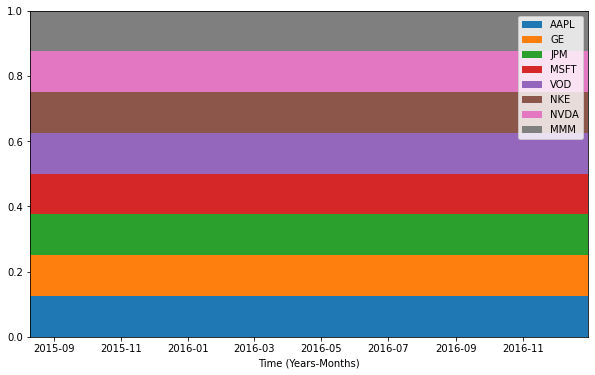

In [ ]:
df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
plt.stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

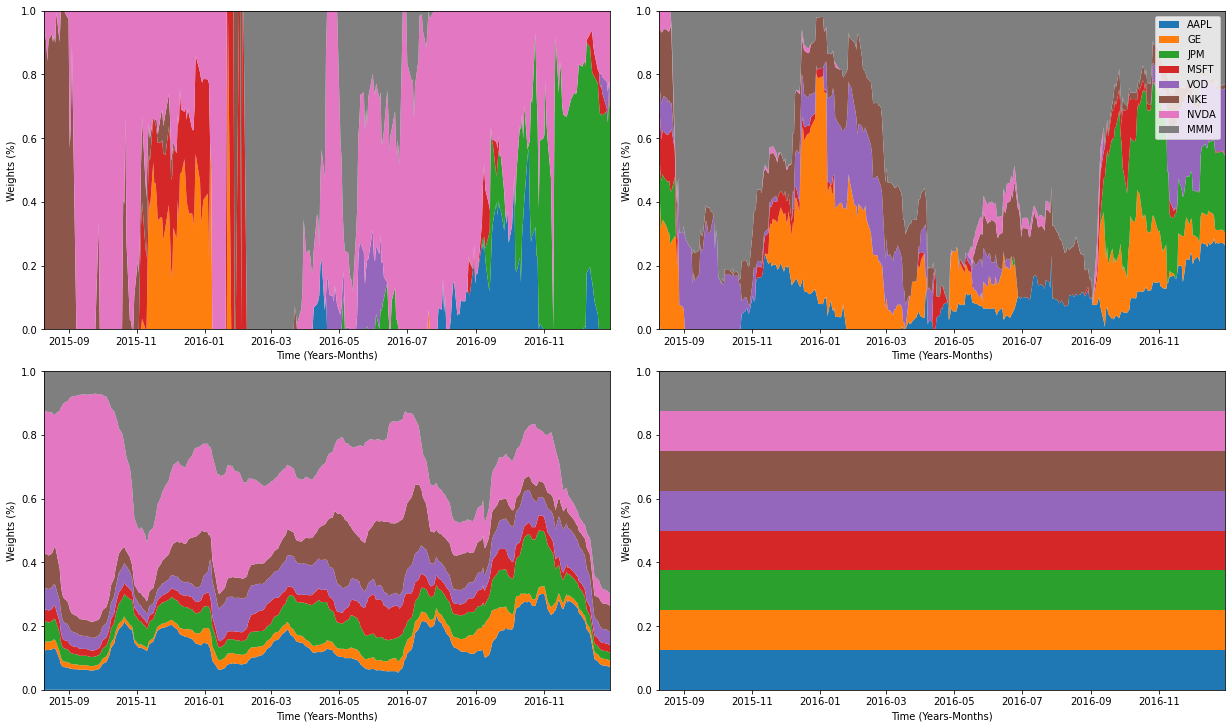

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,10),constrained_layout=True)

df = pd.DataFrame (portfolio_weights_min_var, index = test_re_df.index, columns = tickers)
axs[0,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'])
axs[0,0].margins(x=0)
axs[0,0].margins(y=0)
axs[0,0].set_ylabel("Weights (%)")
axs[0,0].set_xlabel("Time (Years-Months)")

df = pd.DataFrame (portfolio_weights_min_vol, index = test_re_df.index, columns = tickers)
axs[0,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'], labels=tickers)
axs[0,1].legend(loc='upper right')
axs[0,1].margins(x=0)
axs[0,1].margins(y=0)
axs[0,1].set_ylabel("Weights (%)")
axs[0,1].set_xlabel("Time (Years-Months)")

df = pd.DataFrame (portfolio_weights_risk, index = test_re_df.index, columns = tickers)
axs[1,0].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'])
axs[1,0].margins(x=0)
axs[1,0].margins(y=0)
axs[1,0].set_ylabel("Weights (%)")
axs[1,0].set_xlabel("Time (Years-Months)")

df = pd.DataFrame (portfolio_weights_equal, index = test_re_df.index, columns = tickers)
axs[1,1].stackplot(test_re_df.index, df['AAPL'], df['GE'], df['JPM'], df['MSFT'], df['VOD'], df['NKE'], df['NVDA'], df['MMM'])
axs[1,1].margins(x=0)
axs[1,1].margins(y=0)
axs[1,1].set_ylabel("Weights (%)")
axs[1,1].set_xlabel("Time (Years-Months)")


plt.savefig('traditional0.png',bbox_inches='tight')

## Plotting all cumulative returns mtogether

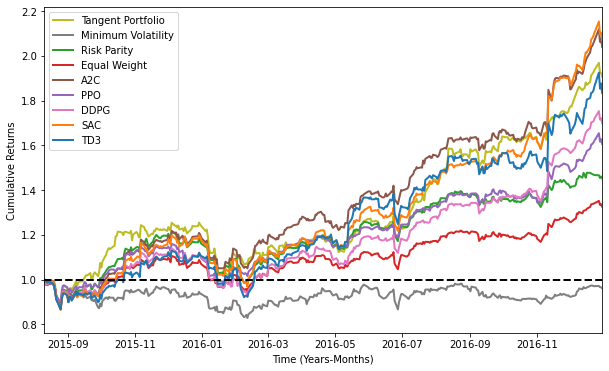

In [ ]:
x = Cumulative_returns_daily_equal.index.values

plt.plot(x, Cumulative_returns_daily_min_var, color='tab:olive', label="Tangent Portfolio", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_min_vol, color='tab:gray', label="Minimum Volatility", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_risk, color='tab:green', label="Risk Parity", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_equal, color='tab:red', label="Equal Weight", linewidth =2.0)

a2c = Cumulative_returns_daily_drl_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = Cumulative_returns_daily_drl_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = Cumulative_returns_daily_drl_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = Cumulative_returns_daily_drl_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = Cumulative_returns_daily_drl_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)

plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_max0.png',bbox_inches='tight')

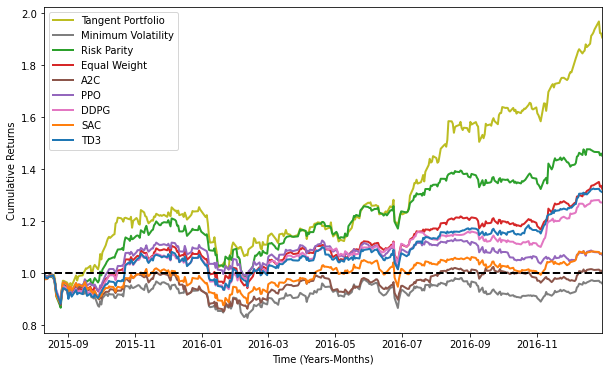

In [ ]:
x = Cumulative_returns_daily_equal.index.values

plt.plot(x, Cumulative_returns_daily_min_var, color='tab:olive', label="Tangent Portfolio", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_min_vol, color='tab:gray', label="Minimum Volatility", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_risk, color='tab:green', label="Risk Parity", linewidth =2.0)
plt.plot(x, Cumulative_returns_daily_equal, color='tab:red', label="Equal Weight", linewidth =2.0)

a2c = Cumulative_returns_daily_drl_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
plt.plot(x, a2c, color='tab:brown', label='A2C', linewidth =2.0)
ppo = Cumulative_returns_daily_drl_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
plt.plot(x, ppo, color='tab:purple', label='PPO', linewidth =2.0)
ddpg = Cumulative_returns_daily_drl_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
plt.plot(x, ddpg, color='tab:pink', label='DDPG', linewidth =2.0)
sac = Cumulative_returns_daily_drl_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
plt.plot(x, sac, color='tab:orange', label='SAC', linewidth =2.0)
td3 = Cumulative_returns_daily_drl_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
plt.plot(x, td3, color='tab:blue', label='TD3', linewidth =2.0)

plt.axhline(1, color='black', linestyle='--', linewidth =2.0)
plt.margins(x=0)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")
plt.legend()
plt.savefig(str(rebalance_period)+'_cumulative_returns_min0.png',bbox_inches='tight')

In [ ]:
portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmax(Cumulative_returns_daily_drl_ppo[:,-1])]
return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_),axis=1)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmax(Cumulative_returns_daily_drl_a2c[:,-1])]
return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_),axis=1)

portfolio_weights_ddpg_ = portfolio_weights_ddpg[np.argmax(Cumulative_returns_daily_drl_ddpg[:,-1])]
return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg_),axis=1)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmax(Cumulative_returns_daily_drl_sac[:,-1])]
return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_),axis=1)

portfolio_weights_td3_ = portfolio_weights_td3[np.argmax(Cumulative_returns_daily_drl_td3[:,-1])]
return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3_),axis=1)

In [ ]:
portfolio_weights_ppo_ = portfolio_weights_ppo[np.argmin(Cumulative_returns_daily_drl_ppo[:,-1])]
return_stocks_ppo = np.sum(return_stocks.multiply(portfolio_weights_ppo_),axis=1)

portfolio_weights_a2c_ = portfolio_weights_a2c[np.argmin(Cumulative_returns_daily_drl_a2c[:,-1])]
return_stocks_a2c = np.sum(return_stocks.multiply(portfolio_weights_a2c_),axis=1)

portfolio_weights_ddpg_ = portfolio_weights_ddpg[np.argmin(Cumulative_returns_daily_drl_ddpg[:,-1])]
return_stocks_ddpg = np.sum(return_stocks.multiply(portfolio_weights_ddpg_),axis=1)

portfolio_weights_sac_ = portfolio_weights_sac[np.argmin(Cumulative_returns_daily_drl_sac[:,-1])]
return_stocks_sac = np.sum(return_stocks.multiply(portfolio_weights_sac_),axis=1)

portfolio_weights_td3_ = portfolio_weights_td3[np.argmin(Cumulative_returns_daily_drl_td3[:,-1])]
return_stocks_td3 = np.sum(return_stocks.multiply(portfolio_weights_td3_),axis=1)

In [ ]:
return_stocks_ppo
return_stocks_a2c
return_stocks_ddpg
return_stocks_sac
return_stocks_td3
return_stocks_min_var
return_stocks_min_vol
return_stocks_risk
return_stocks_equal
print("")

## Other statistics

In [ ]:
!pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 KB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.3 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88682 sha256=d0c69adc509ae151a33d289a4e96228c059956b9bf6f7b506cce4904448412cc
  Stored in directory: /root/.cache/pip/wheels/75/c7/b9/986a1ba8adb2afce230e1a497dc11aeb33efef4fc8dfd6c649
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39776 sha256=a4003e69503fe116ec2971f36a9d039546f77423b79f77156a5df3fcd74aa4e3
  Stored in directory: /root/.cache/pip/wheels/67/23/d1/a4ef8ff88dc9af7b0eeb1b6fd0d90c6057eaad5a2df25f4e3f
Successfully built pyfolio empyrical


In [ ]:
import pyfolio

/usr/local/lib/python3.9/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_ppo, set_context=False)

/usr/local/lib/python3.9/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2015-08-10
End date,2016-12-30
Total months,16
,Backtest
Annual return,5.0%
Cumulative returns,7.1%
Annual volatility,18.2%
Sharpe ratio,0.36
Calmar ratio,0.41
Stability,0.27
Max drawdown,-12.3%


AttributeError: ignored